In [2]:
# IMPORTS AND OVERVIEW
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
from matplotlib.collections import LineCollection


'''
OVERVIEW:

 L(x,y)---------T(x,y)              Top             a = 36.07  [mm] (side length)
 |              |                   /\              e = 22.276 [mm] (edge length)
 |              |                 a/  \b            
 |              |                 /    \            
 |       + (0,0)|            Left/      \Right      T_x,  T_y  =  a/2.0,                 a/2.0               
 EL(x,y)        |                \      /           L_x,  L_y  = -a/2.0,                 a/2.0               
  \             |                c\    /d           R_x,  R_y  =  a/2.0,                -a/2.0               
   \            |                  ====             EL_x, EL_y = -a/2.0,                -a/2.0 + e/np.sqrt(2)
    \ER(x,y)----R(x,y)             edge (e)         ER_x, ER_y = -a/2.0 + e/np.sqrt(2), -a/2.0               
'''
k = ""

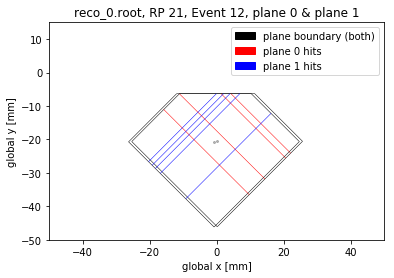

In [27]:
# PLOTTING RP-silicon:
# INPUT:
#   - center (x, y)
#   - redaout direction (dx, dy)
#   - silicon id (to know in which direction U/V is readout)
# OUTPUT:
#   - plot of RP-silicon

class Direction:
    '''
    Wektor jednostkowy
    '''
    def __init__(self, dx=1.0, dy=0.0):
        self.dx = dx
        self.dy = dy
    
    def __repr__(self):
        return "dx = {}\tdy={}".format(self.dx, self.dy)

    def get_perpendicular(self):
        return Direction(self.dy, -self.dx)
        
    
class Vector2D:
    def __init__(self, x=0.0, y=0.0, start=None, end=None):
        if start is None or end is None:
            self.x = x
            self.y = y
        else:
            self.x = end.x - start.x
            self.y = end.y - start.y
                 
    def __repr__(self):
        return "x = {}\ty = {}".format(self.x, self.y)
    

class Point2D:
    def __init__(self, x=0.0, y=0.0):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return "x = {}\ty = {}".format(self.x, self.y)
    
    def move(self, vector):
        self.x += vector.x
        self.y += vector.y
    
    def rotate_around_point(self, other, direction):
        s = direction.dy
        c = direction.dx
        
        new_x = c * (self.x - other.x) - s * (self.y - other.y) + other.x
        new_y = s * (self.x - other.x) + c * (self.y - other.y) + other.y
    
        self.x = new_x
        self.y = new_y

        
class RPSilicon:
    a = 36.07  # side length [mm]
    e = 22.276 # edge length [mm]

    d_T =  Point2D(  a/2.0,                 a/2.0                ) # T
    d_L =  Point2D( -a/2.0,                 a/2.0                ) # L
    d_R =  Point2D(  a/2.0,                -a/2.0                ) # R
    d_EL = Point2D( -a/2.0,                -a/2.0 + e/np.sqrt(2) ) # EL
    d_ER = Point2D( -a/2.0 + e/np.sqrt(2), -a/2.0                ) # ER
    
    def __init__(self, center, direction, siId, T = d_T, L = d_L, R = d_R, EL = d_EL, ER = d_ER):
        self.center = center
        self.direction = direction
        self.siId = siId
        
        self.T = copy.deepcopy(T)
        self.L = copy.deepcopy(L)
        self.R = copy.deepcopy(R)
        self.EL = copy.deepcopy(EL)
        self.ER = copy.deepcopy(ER)
        self.points = [self.R, self.T, self.L, self.EL, self.ER] # In sequence
        
        # MOVE ON CENTER POSITION
        self.move(Vector2D(self.center.x, self.center.y))
        
        # ROTATE AROUND CENTER
        rot_direction = self.get_rot_direction()
        self.rotate_around_center(rot_direction)
    
    def get_rot_direction(self):
        arm = int(self.siId / 1000) 
        if   arm == 0 and self.siId % 2 == 0:  
            return self.direction
        elif arm == 0 and self.siId % 2 == 1:
            return Direction(self.direction.dy, -self.direction.dx)
        elif arm == 1 and self.siId % 2 == 0:
            return Direction(self.direction.dy, -self.direction.dx)
        else:
            return self.direction
    
    def __repr__(self):
        return "T = {} \nL = {} \nR = {} \nEL = {}\nER = {}".format(self.T, self.L, self.R, self.EL, self.ER)

    def move(self, vector):
        for p in self.points:
            p.move(vector)
    
    def rotate_around_center(self, direction):
        for p in self.points:
            p.rotate_around_point(self.center, direction)
    
    def add_to_plot(self, ax, distances, rp_color=[0,0,0,1], hit_color=[1,0,0,1]):
        np_points = np.append(self.points, self.points[0])
        
        # PLOTTING SILICON DETECTOR
        x = np.array([p.x for p in np_points])
        y = np.array([p.y for p in np_points])
        
        starts = [ [x[i], y[i]] for i in range(len(x)-1)]
        ends = [ [x[i+1], y[i+1]] for i in range(len(y)-1)]
        rp_segments = np.array(list(zip(starts,ends)))
        rp_colors = np.full((len(self.points), 4), rp_color) 
         
        rp_line_segments = LineCollection(rp_segments, colors=rp_colors, linewidths=0.5)    
        ax.add_collection(rp_line_segments)
        
        # PLOTTING CENTER POINT
        c_x = [self.center.x]
        c_y = [self.center.y]
        
        ax.plot(c_x, c_y, 'ok', markersize=2, alpha=0.25)
        
        # PLOTTING HIT LINES
        hit_segments = [HitSegment(d, self).get_segment() for d in distances]
        hit_colors = np.full((len(distances), 4), hit_color)

        hit_lines = LineCollection(hit_segments, colors=hit_colors, linewidths=0.5)
        ax.add_collection(hit_lines)

class HitSegment:
    def __init__(self, distance, rp_silicon):
        self.distance = distance
        self.rp_silicon = rp_silicon

    def get_start_vector_fraction(self):
        safe_dist_lower_bound = -RPSilicon.a / 2.0 + RPSilicon.e/np.sqrt(2) # how low position can be not to touch the edge of silicon
        if self.distance >= safe_dist_lower_bound: # hit segment does not touch the silicon edge
            return 0.5
        
        start_segment_length = RPSilicon.a / 2.0 - (safe_dist_lower_bound - self.distance)
        start_segment_fraction = start_segment_length / (RPSilicon.a / 2.0)
        return 0.5 * start_segment_fraction                   
    
    
    def get_hit_segment_vector(self):
        siId = self.rp_silicon.siId
        arm = int(siId / 1000)
        
        vector_RT = Vector2D(start=self.rp_silicon.R, end=self.rp_silicon.T)
        vector_LT = Vector2D(start=self.rp_silicon.L, end=self.rp_silicon.T)
        
        if   arm == 0 and siId % 2 == 0:  
            return vector_RT
        elif arm == 0 and siId % 2 == 1:
            return vector_LT
        elif arm == 1 and siId % 2 == 0:
            return vector_LT
        else:
            return vector_RT
    
    def get_segment(self):
        c_projection = Point2D()
        c_projection.x = self.rp_silicon.center.x + self.distance * self.rp_silicon.direction.dx
        c_projection.y = self.rp_silicon.center.y + self.distance * self.rp_silicon.direction.dy
  
        v = self.get_hit_segment_vector()
    
        vector_k = self.get_start_vector_fraction()
        seg_start = Point2D(c_projection.x - vector_k * v.x, c_projection.y - vector_k * v.y)
        seg_end = Point2D(c_projection.x + 0.5 * v.x, c_projection.y + 0.5 * v.y)
        
        return [(seg_start.x, seg_start.y), (seg_end.x, seg_end.y)]


fig, ax = plt.subplots()
       
si_0 = RPSilicon(Point2D(0.163, -20.594), Direction(-0.706, -0.708), 210)
si_0_distances = [-13.0205, -10.9415, -2.1305, 4.5025]
si_0.add_to_plot(ax, si_0_distances, rp_color=[0, 0, 0, 1], hit_color=[1, 0, 0, 1])

si_1 = RPSilicon(Point2D(-0.788, -20.678), Direction(0.708, -0.706), 211)
si_1_distances = [-9.6215, -8.1035, -6.7505, -4.6715, 6.0865]
si_1.add_to_plot(ax, si_1_distances, rp_color=[0, 0, 0, 1], hit_color=[0, 0, 1, 1])

plt.axis('equal')
plt.axis([-50, 50, -50, 15])
plt.ylabel('global y [mm]')
plt.xlabel('global x [mm]')
ax.set_title('reco_0.root, RP 21, Event 12, plane 0 & plane 1')

rp_patch = mpatches.Patch(color='black', label='plane boundary (both)')
si_0_patch = mpatches.Patch(color='red', label='plane 0 hits')
si_1_patch = mpatches.Patch(color='blue', label='plane 1 hits')
plt.legend(handles=[rp_patch, si_0_patch, si_1_patch])


# p_y = [-34.77415, -34.7783, -34.7959, -34.80915,
#      -32.6277, -32.63185, -32.64945, -32.6627,
#      -30.71456, -30.71872, -30.73631, -30.74956,
#      -27.77486, -27.77902, -27.79661, -27.80986,
#      -12.56308, -12.56723, -12.58483, -12.59808]

# p_x = [-0.2760171, -0.2718532, -0.2542063, -0.2409216,
#      -0.2790488, -0.2748849, -0.257238, -0.2439533,
#      -0.281751, -0.2775871, -0.2599402, -0.2466555,
#      -0.2859031, -0.2817392, -0.2640923, -0.2508076,
#      -0.3073886, -0.3032247, -0.2855778, -0.2722931]

# plt.scatter(p_x, p_y)

plt.show()



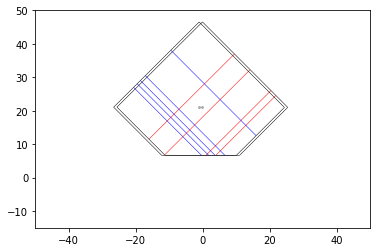

In [30]:
fig, ax = plt.subplots()
       
si_0 = RPSilicon(Point2D(-0.076, 21.043), Direction( -0.706, 0.708), 1240)
si_0_distances = [-13.0205, -10.9415, -2.1305, 4.5025]
si_0.add_to_plot(ax, si_0_distances, rp_color=[0, 0, 0, 1], hit_color=[1, 0, 0, 1])

si_1 = RPSilicon(Point2D(-1.063, 21.017), Direction( 0.708, 0.706), 1241)
si_1_distances = [-9.6215, -8.1035, -6.7505, -4.6715, 6.0865]
si_1.add_to_plot(ax, si_1_distances, rp_color=[0, 0, 0, 1], hit_color=[0, 0, 1, 1])

plt.axis('equal')
plt.axis([-50, 50, -15, 50])

plt.show()

In [31]:
# DATA DICTIONARIES ---> moglem to samo zrobic w pandasie... kurcze to przeciez taki typowy problem... csv to dataframe... :(( SMUTEK, Å»AL I NIEDOWIERZANIE...
'''
POSITION DICT:
{
    silicon_id : {
        'center' : Point2D(),
        'direction' : Direction()
    }
}


HIT DICT:
{
    event_id : {
        rp_id : {
            silicon_id: [position_0, position_1, ... , position_n]
        }
    }
}

RPS DICT:
{
    arm_id : {
        station_id : {
            sub_station : {
                rp_group : rp_id
            }
        }
    }
}

arm_id      in [0,1]
station_id  in [0,2]
sub_station in ['near', 'far']
rp_group    in ['top', 'hor', 'bot']
'''

import csv

def update_hit_dict(hit_dict, event_id, rp_id, silicon_id, position):
    if event_id not in hit_dict:
        hit_dict[event_id] = {}
    if rp_id not in hit_dict[event_id]:
        hit_dict[event_id][rp_id] = {}
    if silicon_id not in hit_dict[event_id][rp_id]:
        hit_dict[event_id][rp_id][silicon_id] = []
    
    hit_dict[event_id][rp_id][silicon_id].append(position)
    
def get_event_rps_silicon_hits_dictionary(csv_filename):
    hit_dict = {}
    
    with open(csv_filename, 'rb') as csv_file:
        reader = csv.reader(csv_file)
        # EventId, RPId, SiliconId, position, u/v, line_no
        header = next(reader)
        
        for row in reader:
            event_id = int(row[0])
            rp_id = int(row[1])
            silicon_id = int(row[2])
            position = float(row[3])
            
            update_hit_dict(hit_dict, event_id, rp_id, silicon_id, position)
            
    return hit_dict
        

def update_position_dict(position_dict, det_id, x, y, z, dx, dy):
    position_dict[det_id] = {
        'center' : Point2D(x,y),
        'direction' : Direction(dx, dy)
    }
    
    
def get_silicon_position_dictionary(csv_filename):
    position_dict = {}
    
    with open(csv_filename, 'rb') as csv_file:
        reader = csv.reader(csv_file)
        # DetId, x, y, z, dx, dy
        header = next(reader)
        
        for row in reader:
            det_id = int(row[0])
            x = float(row[1])
            y = float(row[2])
            z = float(row[3])
            dx = float(row[4])
            dy = float(row[5])
            
            update_position_dict(position_dict, det_id, x, y, z, dx, dy)
    
    return position_dict


def get_rps_dictionary():
    rps_id_in_station ={
        'near' : {'top': 0, 'hor' : 2, 'bot': 1},
        'far' :  {'top': 4, 'hor' : 3, 'bot': 5}
    }

    rps_dict = {}
    for arm_id in [0, 1]:
        rps_dict[arm_id] = {}

        for station_id in [0, 2]:
            rps_dict[arm_id][station_id] = {}

            for sub_station in ['near', 'far']:
                rps_dict[arm_id][station_id][sub_station] = {}

                for rp_group in ['top', 'bot', 'hor']:
                    rp_num = arm_id * 100 + station_id * 10 + rps_id_in_station[sub_station][rp_group]
                    rps_dict[arm_id][station_id][sub_station][rp_group] = rp_num
    return rps_dict
    
hit_dict = get_event_rps_silicon_hits_dictionary('2015_10_17_fill4510_ev24.csv')
position_dict = get_silicon_position_dictionary('2015_10_17_fill4510_sensors.csv')
rps_dict = get_rps_dictionary()

k

''

[103, 104, 105]


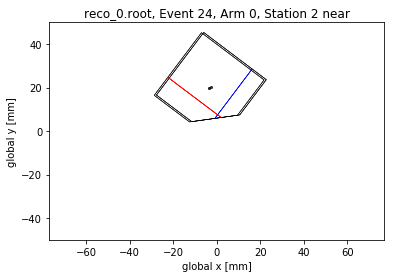

In [32]:
fig, ax = plt.subplots()

def plot_rp_triplet(ax, event_id, arm_id, station_id, sub_station):
    rps_to_plot = rps_dict[arm_id][station_id][sub_station].values()
    print(rps_to_plot)
    
    for rp_id in rps_to_plot:
        dets_to_plot = hit_dict[event_id][rp_id].keys() if rp_id in hit_dict[event_id] else []
        
        for det_id in dets_to_plot:
            det_center = position_dict[det_id]['center']
            det_direction = position_dict[det_id]['direction']
            
            hit_positions = hit_dict[event_id][rp_id][det_id]
            hit_color = [0, 0, 1, 1] if det_id % 2 == 0 else [1, 0, 0, 1]
            rp_color = [0, 0, 0, 1.0 - det_id%10 * 1.0 / 10.0]
            
            silicon = RPSilicon(det_center, det_direction, det_id)
            silicon.add_to_plot(ax, hit_positions, rp_color = rp_color, hit_color = hit_color)

plot_rp_triplet(ax, 24, 1, 0, 'far')

plt.axis('equal')
plt.axis([-100, 100, -50, 50])
plt.ylabel('global y [mm]')
plt.xlabel('global x [mm]')
ax.set_title('reco_0.root, Event 24, Arm 0, Station 2 near')

plt.show()


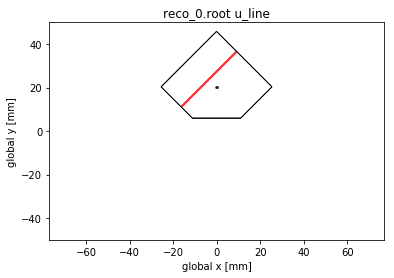

In [33]:
# PLOTTING SINGLE U LINE

det_ids = [ 201, 203, 205, 207, 209 ]

hits = {
 201 : [5.4265],
 203 : [5.1625],
 205 : [4.9645],
 207 : [4.7005],
 209 : [4.5685]
}

def plot_u_line_hits():
    for det_id in det_ids:
        det_center = position_dict[det_id]['center']
        det_direction = position_dict[det_id]['direction']
        hit_positions = hits[det_id]

        silicon = RPSilicon(det_center, det_direction, det_id)
        silicon.add_to_plot(ax, hit_positions)

fig, ax = plt.subplots()

plot_u_line_hits()

plt.axis('equal')
plt.axis([-100, 100, -50, 50])
plt.ylabel('global y [mm]')
plt.xlabel('global x [mm]')
ax.set_title('reco_0.root u_line')

plt.show()


**Ponizej sa juz tylko glupoty**

In [34]:
# Testing Cramers rule

'''
Given two lines:
l1:  ( x1 ) + a ( u1)
     ( y1 ) + a ( v1)

l2:  ( x2 ) + a ( u2)
     ( y2 ) + a ( v2)


[ u1  -u2] * [ a ] = [ x2 - x1 ]
[ v1  -v2]   [ b ]   [ y2 - y1 ]


Cramers rule:

[ a1 b1 ] * [ k_u ] = [ c1 ]
[ a2 b2 ]   [ k_v ]   [ c2 ]

k_u = (c1b2 - b1c2) / (a1b2 - b1a2)
k_v = (a1c2 - c1a2) / (a1b2 - b1a2)
'''

v_c = Point2D(0.163, -20.594)
u_c = Point2D(-0.788, -20.678)

v_dir = Direction(-0.706, -0.708) # even
u_dir = Direction(0.708, -0.706) # odd

v_dist = 4.5025
u_dist = 6.0865

vc_proj = Point2D(
    v_c.x + v_dist * v_dir.dx,
    v_c.y + v_dist * v_dir.dy
)

uc_proj = Point2D(
    u_c.x + u_dist * u_dir.dx,
    u_c.y + u_dist * u_dir.dy
)

v_dir_perp = v_dir.get_perpendicular()
u_dir_perp = u_dir.get_perpendicular()

# moja kolejnosc literek v, u, wiec v - 1, u - 2
c1 = uc_proj.x - vc_proj.x
c2 = uc_proj.y - vc_proj.y

b1 = - u_dir_perp.dx
b2 = - u_dir_perp.dy

a1 = v_dir_perp.dx
a2 = v_dir_perp.dy

k_v = (c1 * b2 - b1 * c2) / (a1 * b2 - b1 * a2)

uv_intersection = Point2D(
    vc_proj.x + k_v * v_dir_perp.dx,
    vc_proj.y + k_v * v_dir_perp.dy
)

uv_intersection


x = 0.858631714414	y = -27.6452220909